In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from glob import glob
import cv2
from matplotlib import animation
from IPython import display
from tqdm.auto import trange, tqdm

In [2]:
train_descriptions = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
train_coord_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
train_coord_df = train_coord_df.merge(train_descriptions, on=["series_id", "study_id"], how="left")
train_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")

In [3]:
train_coord_df

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,Sagittal T1
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,Sagittal T1
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,Sagittal T1
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,Sagittal T1


In [10]:
train_coord_df[(train_coord_df.series_description == "Sagittal T1") & (train_coord_df.condition == "Left Neural Foraminal Narrowing")].groupby("series_id").count().loc[:, "study_id"].value_counts()

study_id
5    1972
Name: count, dtype: int64

In [11]:
train_coord_df[(train_coord_df.series_description == "Sagittal T1") & (train_coord_df.condition == "Right Neural Foraminal Narrowing")].groupby("series_id").count().loc[:, "study_id"].value_counts()

study_id
5    1971
4       1
Name: count, dtype: int64

In [8]:
train_coord_df[train_coord_df.series_description == "Sagittal T2/STIR"].groupby("series_id").count().loc[:, "study_id"].value_counts()

study_id
5    1898
3      39
4      35
1       1
Name: count, dtype: int64

In [4]:
max_instance_number = {}

for i in tqdm(train_coord_df.series_id.unique()):
    max_instance_number.update(dict(i=len(glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{i}/*"))))
max_instance_number

  0%|          | 0/6291 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
idx = 2000

In [6]:
coord_label_num = train_coord_df.groupby("series_id").count().study_id
# new_train_coord_df = train_coord_df[~train_coord_df.series_id.isin(train_coord_df.groupby("series_id").count()[coord_label_num % 5 != 0].reset_index().series_id.to_numpy())].sort_values(by=["series_id", "level"]).reset_index(drop=True)
new_train_coord_df = train_coord_df.sort_values(by=["study_id", "series_id", "level", "condition"]).reset_index(drop=True)
new_train_coord_df = train_coord_df[~train_coord_df.series_id.isin(train_coord_df.groupby("series_id").count()[coord_label_num % 5 != 0].reset_index().series_id.to_numpy())].sort_values(by=["series_id", "level"]).reset_index(drop=True)
# new_train_coord_df = train_coord_df[train_coord_df.series_id.isin(train_coord_df.groupby("series_id").count()[coord_label_num % 5 != 0].reset_index().series_id.to_numpy())].sort_values(by=["series_id", "level"]).reset_index(drop=True)
series_ids = new_train_coord_df.series_id.unique()
series_df = new_train_coord_df[new_train_coord_df.series_id == series_ids[idx]]
idx += 1
series_df

,study_id,series_id,instance_number,condition,level,x,y,series_description
16165,305152236,1523080825,5,Right Neural Foraminal Narrowing,L1/L2,254.023861,89.544469,Sagittal T1
16166,305152236,1523080825,11,Left Neural Foraminal Narrowing,L1/L2,243.405797,94.608696,Sagittal T1
16167,305152236,1523080825,4,Right Neural Foraminal Narrowing,L2/L3,241.529284,129.527115,Sagittal T1
16168,305152236,1523080825,11,Left Neural Foraminal Narrowing,L2/L3,231.657005,128.618357,Sagittal T1
16169,305152236,1523080825,4,Right Neural Foraminal Narrowing,L3/L4,228.201735,174.507592,Sagittal T1
16170,305152236,1523080825,12,Left Neural Foraminal Narrowing,L3/L4,222.381643,166.338164,Sagittal T1
16171,305152236,1523080825,5,Right Neural Foraminal Narrowing,L4/L5,223.004320,210.246220,Sagittal T1
16172,305152236,1523080825,14,Left Neural Foraminal Narrowing,L4/L5,221.144928,199.729469,Sagittal T1
16173,305152236,1523080825,6,Right Neural Foraminal Narrowing,L5/S1,221.537961,243.644252,Sagittal T1
16174,305152236,1523080825,16,Left Neural Foraminal Narrowing,L5/S1,221.144928,231.265700,Sagittal T1


In [7]:
instance_num = {sd: [] for sd in new_train_coord_df.series_description.unique()}
for i in trange(len(series_ids)):
    series_df = new_train_coord_df[new_train_coord_df.series_id == series_ids[i]]
    instance_num[series_df.series_description.iloc[0]].append(len(glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_df.series_id.iloc[0]}/*")))

  0%|          | 0/5662 [00:00<?, ?it/s]

In [8]:
instance_num.keys()

dict_keys(['Sagittal T1', 'Axial T2', 'Sagittal T2/STIR'])

(array([848., 695., 229.,   1.,   0.,   0.,   0.,   1.,   3.,   9.]),
 array([ 15. ,  32.7,  50.4,  68.1,  85.8, 103.5, 121.2, 138.9, 156.6,
        174.3, 192. ]),
 <BarContainer object of 10 artists>)

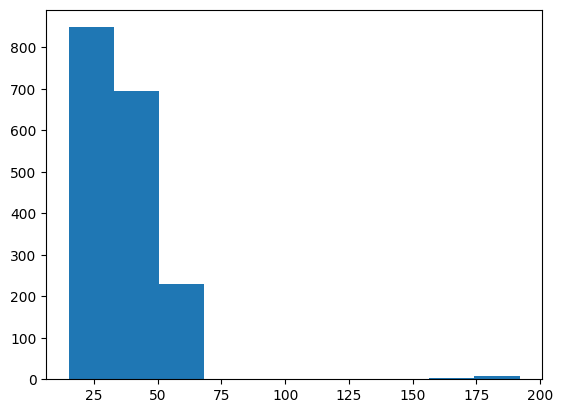

In [9]:
plt.hist(np.asarray(instance_num['Axial T2']))

(array([110., 667., 704., 402.,  65.,  26.,   3.,   0.,   0.,   1.]),
 array([10. , 12.8, 15.6, 18.4, 21.2, 24. , 26.8, 29.6, 32.4, 35.2, 38. ]),
 <BarContainer object of 10 artists>)

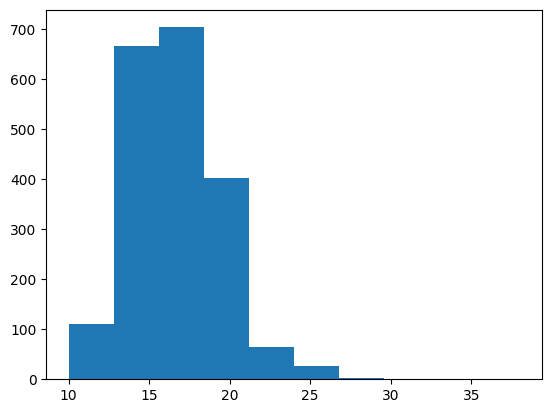

In [10]:
plt.hist(np.asarray(instance_num['Sagittal T1']))

(array([  3., 106., 127., 579., 596., 239., 176.,  47.,  22.,   3.]),
 array([ 8. , 10.1, 12.2, 14.3, 16.4, 18.5, 20.6, 22.7, 24.8, 26.9, 29. ]),
 <BarContainer object of 10 artists>)

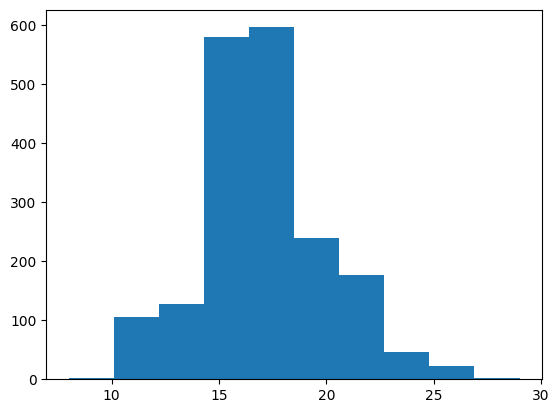

In [11]:
plt.hist(np.asarray(instance_num['Sagittal T2/STIR']))